In [ ]:
import numpy as np
from pyTsetlinMachineParallel.tm import MultiClassConvolutionalTsetlinMachine2D
from time import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import csv
from matplotlib.font_manager import FontProperties
from collections import Counter
import pickle
import wandb

# Load the Data

In [ ]:
def load_data():
    x_train = np.load('k49-train-imgs.npz')['arr_0']
    y_train = np.load('k49-train-labels.npz')['arr_0']
    x_test = np.load('k49-test-imgs.npz')['arr_0']
    y_test = np.load('k49-test-labels.npz')['arr_0']

    # Normalize images
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_data()

# Analyze Data  

Number of classes: 10
Image shape: (28, 28)


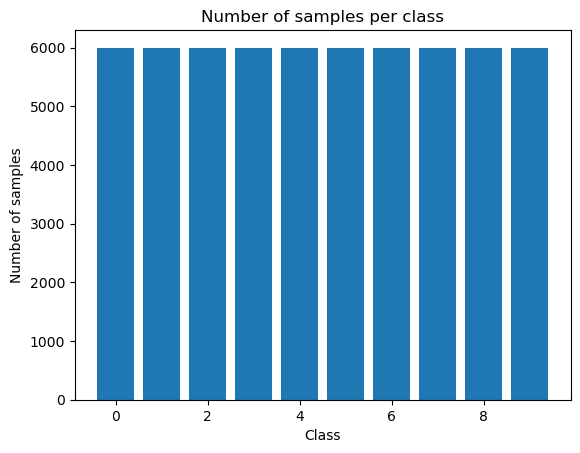

In [3]:
num_classes = len(set(y_train))
num_samples_per_class = Counter(y_train, axis=0)
img_shape = x_train.shape[1:]
print('Number of classes:', num_classes)
print('Image shape:', img_shape)
plt.figure()
plt.bar(range(num_classes), [num_samples_per_class[i] for i in range(num_classes)])
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Number of samples per class')
plt.show()

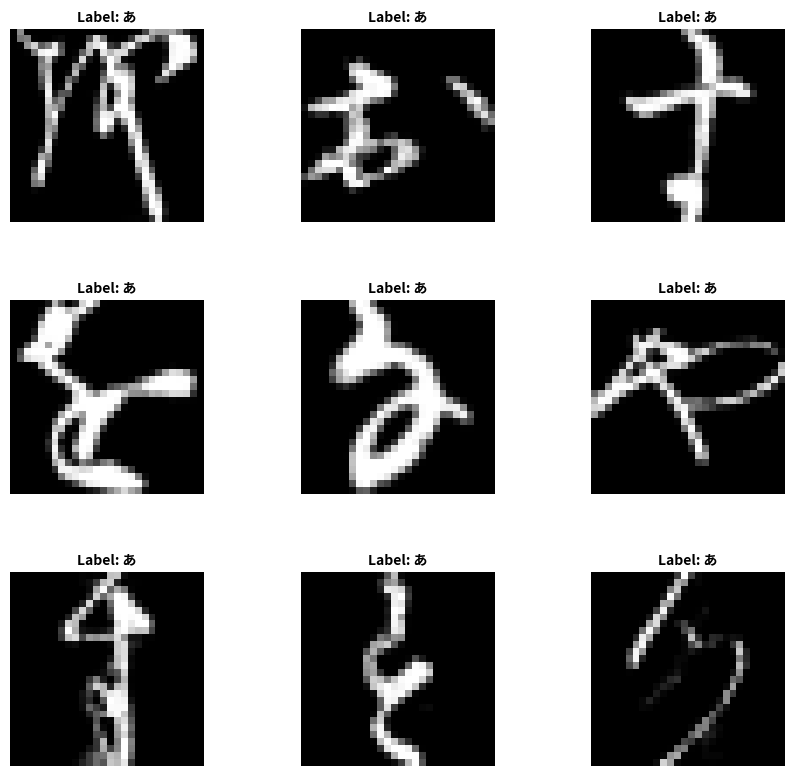

In [4]:
def plot_samples(x_train, y_train, class_labels):
    fp = FontProperties(fname='static/NotoSansJP-Bold.ttf')
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))    
    axes = axes.ravel()
    
    for i in range(9):
        idx = np.random.randint(0, len(x_train))
        img = x_train[idx]
        label = np.argmax(y_train[idx])  # Convert one-hot to index
        label = class_labels[label] if class_labels else label
        
        axes[i].imshow(img.squeeze(), cmap='gray')  # Use squeeze to remove single-dimensional entries from the shape
        axes[i].set_title(f'Label: {label}', fontproperties=fp)
        axes[i].axis('off')
        
    plt.subplots_adjust(wspace=0.5)

# Load class labels
with open('k49_classmap.csv') as f:
    reader = csv.reader(f)
    next(reader)  # Skip header
    class_labels = {int(label): desc for label, _, desc in reader}

plot_samples(x_train, y_train, class_labels)

# Define the NN Architecture

In [5]:
def create_model(number_of_clauses=10000, T=5000, s=5.0, patch_shape=(10, 10), weighted_clauses=True):
    return MultiClassConvolutionalTsetlinMachine2D(number_of_clauses, T, s, patch_shape, weighted_clauses=weighted_clauses)


# Create the Model

In [6]:
model = create_model()

In [7]:
wandb.init(project='hiragana_classification', entity='gabri-torland', name="last k49 with 100 epochs",config={"num_classes": num_classes, "img_shape": img_shape, 'number_of_clauses': 10000, 'T': 5000, 's': 5.0, 'patch_shape': (10, 10), 'weighted_clauses': True})

wandb: Currently logged in as: gabri-torland. Use `wandb login --relogin` to force relogin


Problem at: /opt/conda/lib/python3.11/site-packages/wandb/sdk/wandb_init.py 849 getcaller



KeyboardInterrupt



# Train the Model

In [ ]:
print("\nAccuracy over 20 epochs:\n")
for i in range(20):
	start = time()
	model.fit(x_train, y_train, epochs=1, incremental=True)
	stop = time()
	
	result = 100*(model.predict(x_test) == y_test).mean()
	
	print("#%d Accuracy: %.2f%% (%.2fs)" % (i+1, result, stop-start))

	wandb.log({"accuracy": result})

state = model.__getstate__()
with open("model.pk1", 'wb') as file:
	pickle.dump(state, file)

wandb.save('model.pk1')